In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../')
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy import sparse
from concentration import logistic, classical_logistic_interval, pp_logistic_interval
from ols_utils import transform_features
from tqdm import tqdm
import pdb

from logistic_utils import get_data, plot_data, get_tree, make_plots, acs_filter

/Users/angelopoulos/miniconda3/envs/mai/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Interval Constructions

In [2]:
def trial(X, Y, Yhat, true, n, alpha):
    X_labeled, X_unlabeled, Y_labeled, Y_unlabeled, Yhat_labeled, Yhat_unlabeled = train_test_split(X, Y, Yhat, train_size=n)

    imputed_interval = classical_logistic_interval(X, Yhat, alpha)

    classical_interval = classical_logistic_interval(X_labeled, Y_labeled, alpha)

    pp_interval = pp_logistic_interval(X_labeled, X_unlabeled, Y_labeled, Yhat_labeled, Yhat_unlabeled, alpha)

    return imputed_interval, classical_interval, pp_interval

## Monte Carlo Trials of Experiment

In [3]:
# Train tree on last year's data
curr_year = 2019
transform = False
# Feature codes to use
feature_names =['PINCP','AGEP', 'PUBCOV','SCHL','MAR','SCH','DIS','ESP','CIT','MIG','MIL','ANC','NATIVITY','DEAR','DEYE','DREM','SEX','RAC1P']
ft = np.array(["q", "q", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c"])
regression_feature_name = "PINCP"
outcome_name = "PRIVCOV"
features, outcome = get_data(curr_year, feature_names, outcome_name, regression_feature_name, acs_filter=acs_filter)
reg_feat = features[regression_feature_name]
if transform:
    features, enc = transform_features(features, ft)
else:
    enc = None

In [4]:
print(outcome.std())
print(outcome.to_numpy())

0.46990246008817266
[1 1 1 ... 1 0 0]


In [5]:
np.random.seed(0) # Fix seed for tree
tree = get_tree(curr_year-1, feature_names, ft, outcome_name, regression_feature_name, enc=enc, transform=transform, acs_filter=acs_filter)
np.random.seed(0) # Fix seed for evaluation
# Evaluate tree and plot data
predicted_outcome = tree.predict(xgb.DMatrix(features))

/Users/angelopoulos/miniconda3/envs/mai/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [6]:
print( (outcome - predicted_outcome).std() )
print(predicted_outcome)

0.33244264441511984
[0.80073285 0.6619912  0.01801275 ... 0.9628118  0.08507966 0.09303182]


In [7]:
# Collect logistic features
X = np.stack([reg_feat, np.ones_like(reg_feat)], axis=1)
X[:,1] = X[:,1] * (np.linalg.norm(X, axis=0)[0] / np.linalg.norm(X, axis=0)[1])
true = logistic(X, outcome.to_numpy())

print(f"True logistic regression coefficients: {true}")

try:
    df = pd.read_pickle('./.cache/logistic-results.pkl')
except:
    N = features.shape[0]
    ns = np.array([200, 300, 500, 1000, 2000, 5000, 10000])
    num_trials = 10
    alpha = 0.05

    # Store results
    columns = ["lb","ub","covered","estimator","n"]

    results = []
    for j in tqdm(range(ns.shape[0])):
        for i in range(num_trials):
            n = ns[j]
            ii, ci, ppi = trial(X, outcome.to_numpy(), predicted_outcome, true, n, alpha)
            temp_df = pd.DataFrame(np.zeros((3,len(columns))), columns=columns)
            temp_df.loc[0] = ii[0][0], ii[1][0], (ii[0][0] <= true[0]) & (true[0] <= ii[1][0]), "imputed", n
            temp_df.loc[1] = ci[0][0], ci[1][0], (ci[0][0] <= true[0]) & (true[0] <= ci[1][0]), "classical", n
            temp_df.loc[2] = ppi[0][0], ppi[1][0], (ppi[0][0] <= true[0]) & (true[0] <= ppi[1][0]), "prediction-powered", n
            results += [temp_df]
    df = pd.concat(results)
    df["width"] = df["ub"] - df["lb"]
    df.to_pickle('./.cache/logistic-results.pkl')

True logistic regression coefficients: [1.91335746e-05 1.86659901e-07]


/Users/angelopoulos/Code/working/prediction-powered-inference/census/logistic_utils.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['', '<20K', '20K-40K','40K-60K','60K-80K','80K-100K', '>100K'])


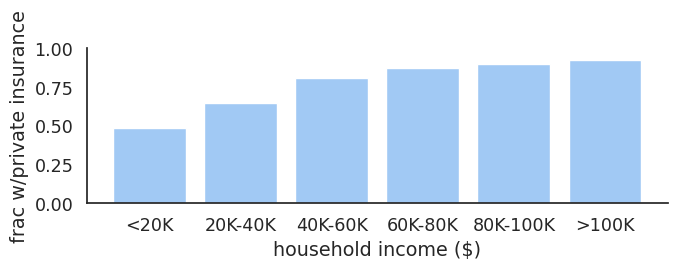

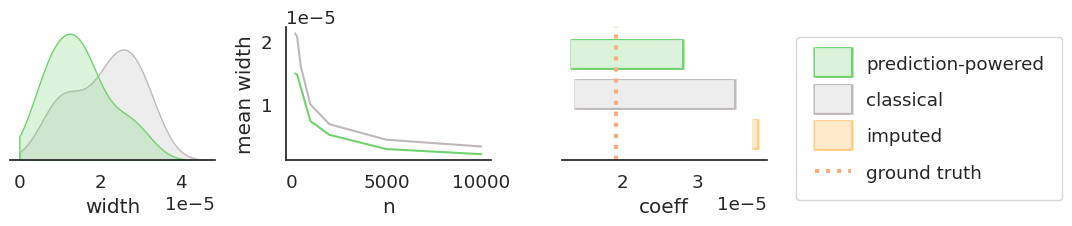

In [8]:
plot_data(reg_feat, outcome)
make_plots(df, true)